In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

In [2]:
#read CSV data and convert to Pandas Dataframe for column exctraction, then check type.
g2_data = pd.read_csv("C:/Users/maris/Documents/QC_Modeling_Bayesian/data/cross_div1.csv", usecols=['photon_spacing', 'g2'])
# print(g2_data.head())
g2_array = np.array(g2_data['g2'])
time_array = np.array(g2_data['photon_spacing'])
print(len(g2_array), len(time_array));
x0 = 10e5;
time = time_array / x0

100 100


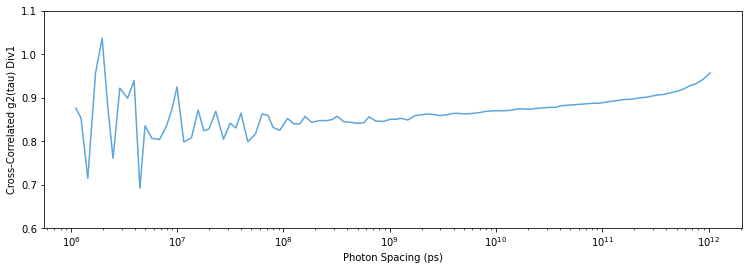

In [3]:
# Defining our Data into tensor array for TFP from Pd.Array type
# # Visualizing the Results as a check 
plt.figure(figsize=(12.5, 4))
plt.plot(time_array, g2_array, color="#5DA5DA")
#Arbitary x-label to match Andrews 20201031 MatLab axes
plt.xlabel("Photon Spacing (ps)")
plt.ylabel("Cross-Correlated g2(tau) Div1")
plt.xscale('log')
# plt.xlim(10e5, 1e12);
plt.ylim(0.6, 1.1);

In [5]:
# set random seed for reproducibility
np.random.seed(12345)
x = time_array

# Parameters for gaussian
amp_int = 0.1
gamma_coeff_int = 1.0
gamma_coeff_2_int = 1e-6
offset_int = 0.86

# Fit based on Cortes S20 with no oscillations, 
fit = lambda x,amp, gamma_coeff, gamma_coeff_2, offset: ((amp - amp * (np.exp(-gamma_coeff*(x/x0)) + np.exp(-gamma_coeff_2*(x/x0)) )
                                                                 ) + offset)
model = fit(x=x, amp=amp_int, gamma_coeff=gamma_coeff_int, gamma_coeff_2=gamma_coeff_2_int, offset=offset_int)

# fit = lambda x,amp, gamma_coeff, offset: (amp - amp * (np.exp(-gamma_coeff*(x / 10e5))) + offset)
# model = fit(x=x, amp=amp_int, gamma_coeff=gamma_coeff_int, offset=offset_int)

#Determine absolute error between Model and g2_from_qutip
# add noise to the data points
noise = np.random.normal(size=len(x)) * .04 
model_noise = model + noise 
model__noise_error = np.abs(model-model_noise)
model_error = np.abs(model - g2_array)

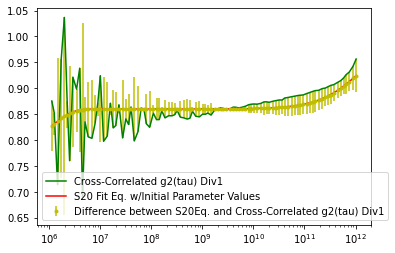

In [6]:
plt.plot(x, g2_array, color='g', label="Cross-Correlated g2(tau) Div1")
plt.plot(x, model, color='r', label="S20 Fit Eq. w/Initial Parameter Values")
# plt.plot(x, model_noise, color='b', label=" Fit Eq. + Noise")
# plt.plot(x, model__noise_error, color='g', label="Difference between S20Eq. and S20 with Noise")
# plt.plot(x, model_error, color='y', label="Difference between S20Eq. and Cross-Correlated g2(tau) Div1")
plt.errorbar(x, model, yerr=model_error, color='y', marker='.', ls='None', label="Difference between S20Eq. and Cross-Correlated g2(tau) Div1");
plt.xscale('log')
# plt.xlim(10e4, 10e12)
# plt.ylim(-1,2)
plt.legend();
# plt.savefig("Fig1")
np.savetxt('20200611_Cross_g2_ExpData.csv', g2_array, delimiter=',' )

In [7]:
with pm.Model() as model3:
    amp = pm.Uniform('amp', 0.01, 1.0, testval =  0.2 )
    gamma_coeff = pm.Normal('gamma_coeff', 1.0, 100.0, testval = 1.0 )
    gamma_coeff_2 = pm.Normal('gamma_coeff_2', 1.0, 100.0, testval = 1.0 )
    offset = pm.Normal('offset', 0.01, 3.0, testval = 0.9)

    fit=pm.Deterministic('fit', (amp - amp * (np.exp(-gamma_coeff*(x / x0)) + np.exp(-gamma_coeff_2*(x / x0)) ) + offset))
#   mu deterministic parameters
    y =pm.Normal('y', mu=fit, tau=1.0/model_error**2, observed=g2_array)

In [ ]:
with model3:
    start=pm.find_MAP()
#     step=pm.NUTS()
    trace=pm.sample(200)

logp = 208.91, ||grad|| = 2.3225: 100%|███████████████| 236/236 [00:00<00:00, 2329.41it/s]
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, gamma_coeff_2, gamma_coeff, amp]


In [ ]:
with model3:
    az.plot_trace(trace, var_names=["amp","gamma_coeff","gamma_coeff_2","offset"])
#     plt.savefig("Fig2")

In [ ]:
# extract and plot results
y_min = np.percentile(trace.fit, 2.5, axis=0)
y_max = np.percentile(trace.fit, 97.5, axis=0)
y_fit = np.percentile(trace.fit, 50, axis=0)

plt.plot(x, g2_array,'r', label='Cross-Correlated g2(tau)')
# plt.plot(time_array, model_noise,'b', marker='None', ls='-', lw=1, label='S20 Model with Noise')
plt.errorbar(x, model, yerr=model_error, color='y', marker='.', ls='None', label='Likelihood (sampling distribution) of Cross-Correlated g2(tau)Data')
plt.plot(x, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit with S20 using Priors')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend();
plt.xscale('log')
plt.ylabel("Fit Eq.");
plt.xlabel("Time(arb.)");
# plt.savefig("Fig3")

In [55]:
#MAP Details
start;

In [260]:
np.savetxt('Cross_corr_div10_double_exp.csv', y_fit, delimiter=',' )